## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import time
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
# Print the arm state
robot.getJointStates()

{'q': array([ 8.84688348e-04, -7.84864859e-01,  3.58368437e-03, -2.35602531e+00,
        -9.49452847e-04,  1.57109183e+00,  7.86512442e-01]),
 'dq': array([-0.00070358,  0.00024426, -0.00076728, -0.00084068,  0.00038386,
        -0.00151395,  0.00159043]),
 'T': array([-0.1355927 , -4.34961081, -0.82716978, 23.04416275,  0.97154462,
         2.16794562, -0.12952206]),
 'M': array([[ 4.93132462e-01, -1.20301351e-02,  4.91380674e-01,
         -1.01527657e-02,  6.16215271e-02, -2.87504121e-03,
          1.29776855e-03],
        [-1.20301351e-02,  1.54910092e+00,  3.67567523e-03,
         -7.02396267e-01, -1.28381766e-02, -2.24852764e-02,
         -1.54525756e-03],
        [ 4.91380674e-01,  3.67567523e-03,  9.96014415e-01,
         -2.57398299e-02,  7.51873284e-02, -3.66408564e-03,
          3.25291655e-03],
        [-1.01527657e-02, -7.02396267e-01, -2.57398299e-02,
          9.73343136e-01,  2.54496885e-02,  1.11769375e-01,
         -1.76390420e-04],
        [ 6.16215271e-02, -1.2838176

### 1.2 Set up communication with the gripper

In [ ]:
# from fr3_gripper import Gripper, GripperState
# gripper = Gripper("192.168.123.250")

# Initialize the gripper
# gripper.homing()

# # Print the gripper state
# gripper_state = gripper.readOnce()
# print(gripper_state)

## 2. Define robot task parameters

### 2.1 Load PinocchioModel and define various parameters

In [3]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.15, -0.15, -0.15])
v_EE_ub = np.array([0.15, 0.15, 0.15])
static_friction = np.array([0.8, 2.35, 0.5, 2.35, 1.3, 1.0, 0.5])

n_joints = 7
n_controls = 7
q_bar = 0.5*(joint_ub + joint_lb)
delta_M = np.diag([0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2])

## 3. Load/measure some coordinates

### 3.1 Measure the corners

In [4]:
# corner_1         corner_2
#     -----------------
#     |               |
#     |               | 
#     |               |
#     |               |
#     |               |
#     |               |   x Robot base
#     -----------------
# corner_4         corner_3
# *** corner_1 is out of reach of the robot

In [42]:
# Measure corner_2
corner_2_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    corner_2_mes.append(P_EE.copy())
    time.sleep(0.1)

corner_2_mes = np.array(corner_2_mes)
corner_2 = np.mean(corner_2_mes, axis=0)[:2]
print("corner_2: ", corner_2)

corner_2:  [0.61486314 0.26944065]


In [44]:
# Measure corner_3
corner_3_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    corner_3_mes.append(P_EE.copy())
    time.sleep(0.1)

corner_3_mes = np.array(corner_3_mes)
corner_3 = np.mean(corner_3_mes, axis=0)[:2]
print("corner_3: ", corner_3)

corner_3:  [-0.24312932  0.28365992]


In [45]:
# Measure corner_4
corner_4_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    corner_4_mes.append(P_EE.copy())
    time.sleep(0.1)

corner_4_mes = np.array(corner_4_mes)
corner_4 = np.mean(corner_4_mes, axis=0)[:2]
print("corner_4: ", corner_4)

corner_4:  [-0.23795498  0.82884581]


In [58]:
# Calculate corner_1 (ignore the z coordinate)
corner_1 = corner_2 + corner_4 - corner_3
print("corner_1: ", corner_1)

corner_1:  [0.62003748 0.81462653]


### 3.2 Measure the polygon vertices

In [88]:
# Measure vertex_1
vertex_1_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    vertex_1_mes.append(P_EE.copy())
    time.sleep(0.1)

vertex_1_mes = np.array(vertex_1_mes)
vertex_1 = np.mean(vertex_1_mes, axis=0)[:2]
print("vertex_1: ", vertex_1)

vertex_1:  [0.30743286 0.59065426]


In [84]:
# Measure vertex_2
vertex_2_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    vertex_2_mes.append(P_EE.copy())
    time.sleep(0.1)

vertex_2_mes = np.array(vertex_2_mes)
vertex_2 = np.mean(vertex_2_mes, axis=0)[:2]
print("vertex_2: ", vertex_2)

vertex_2:  [0.31173321 0.27875121]


In [85]:
# Measure vertex_3
vertex_3_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    vertex_3_mes.append(P_EE.copy())
    time.sleep(0.1)

vertex_3_mes = np.array(vertex_3_mes)
vertex_3 = np.mean(vertex_3_mes, axis=0)[:2]
print("vertex_3: ", vertex_3)

vertex_3:  [0.08136865 0.27995354]


In [86]:
# Measure vertex_4
vertex_4_mes = []
for i in range(20):
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.30*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]

    vertex_4_mes.append(P_EE.copy())
    time.sleep(0.1)

vertex_4_mes = np.array(vertex_4_mes)
vertex_4 = np.mean(vertex_4_mes, axis=0)[:2]
print("vertex_4: ", vertex_4)

vertex_4:  [0.07530274 0.5910794 ]


### 3.3 Save the measured coordinates

In [ ]:
# Save the corners in a json file
import json
corners = {"corner_1": corner_1.tolist(),
           "corner_2": corner_2.tolist(),
           "corner_3": corner_3.tolist(),
           "corner_4": corner_4.tolist(),
           "vertex_1": vertex_1.tolist(),
           "vertex_2": vertex_2.tolist(),
           "vertex_3": vertex_3.tolist(),
           "vertex_4": vertex_4.tolist()
           }
with open("exp2_coordinates.json", "w") as f:
    json.dump(corners, f, indent=4)

### 3.4 Directly load the pre-saved corners

In [4]:
import json
with open("exp2_coordinates.json", "r") as f:
    coordinates = json.load(f)
    corner_1 = np.array(coordinates["corner_1"])
    corner_2 = np.array(coordinates["corner_2"])
    corner_3 = np.array(coordinates["corner_3"])
    corner_4 = np.array(coordinates["corner_4"])
    vertex_1 = np.array(coordinates["vertex_1"])
    vertex_2 = np.array(coordinates["vertex_2"])
    vertex_3 = np.array(coordinates["vertex_3"])
    vertex_4 = np.array(coordinates["vertex_4"])

### 3.5 Visualize the coordinates

(0.856816067701903,
 0.24147038763965387,
 -0.2862876548138651,
 0.6631958200080065)

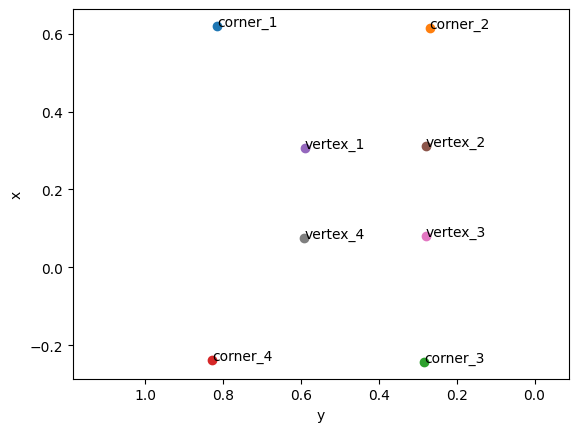

In [5]:
import matplotlib.pyplot as plt

# plot the points in 3d space with z=0
fig = plt.figure()


plt.plot(corner_1[1], corner_1[0], 'o')
plt.text(corner_1[1], corner_1[0], 'corner_1')

plt.plot(corner_2[1], corner_2[0], 'o')
plt.text(corner_2[1], corner_2[0], 'corner_2')

plt.plot(corner_3[1], corner_3[0], 'o')
plt.text(corner_3[1], corner_3[0], 'corner_3')

plt.plot(corner_4[1], corner_4[0], 'o')
plt.text(corner_4[1], corner_4[0], 'corner_4')

plt.plot(vertex_1[1], vertex_1[0], 'o')
plt.text(vertex_1[1], vertex_1[0], 'vertex_1')

plt.plot(vertex_2[1], vertex_2[0], 'o')
plt.text(vertex_2[1], vertex_2[0], 'vertex_2')

plt.plot(vertex_3[1], vertex_3[0], 'o')
plt.text(vertex_3[1], vertex_3[0], 'vertex_3')

plt.plot(vertex_4[1], vertex_4[0], 'o')
plt.text(vertex_4[1], vertex_4[0], 'vertex_4')

# Invert the x-axis (make it go left)
plt.gca().invert_xaxis()
plt.xlabel('y')
plt.ylabel('x')
plt.axis('equal')

# 

## 4. Define Obstacles and CBFs

In [7]:
# Obstacle parameters
obstacle_config = {
    "obs1":{
        "type": "polytope2d",
        "vertices": [vertex_1.tolist(), vertex_2.tolist(), vertex_3.tolist(), vertex_4.tolist()],
        "pos": [0.0, 0.0],
        "theta": 0.0
    }
}

In [8]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix

n_polytope = len(obstacle_config)
obs_col = PolytopeCollection(2, n_polytope, obstacle_config)

obstacle_kappa = 50.0


/workspaces/HOCBF-FR3-Experiments/cores/obstacle_collections/polytope_collection.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='single')


## 5. Control the arm to pre-cleaning pose

In [10]:
# Define tracking gains
K_p_pos = np.diag([100,100,100])*0.9
K_d_pos = np.diag([50,50,50])*0.5

K_p_rot = np.diag([200,200,200])*1.8
K_d_rot = np.diag([100,100,100])*0.4

Kp_joint = 20*np.diag([1, 1, 1, 1, 1, 1, 1])
Kd_joint = 10*np.diag([1, 1, 1, 1, 1, 1, 1])

In [33]:
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
t_final = 6

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_pre_cleaning = np.array([0.48, 0.41, 0.02])

via_points = np.array([P_EE_start, P_EE_pre_cleaning])
target_time = np.array([0, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = 0
R_EE_pre_grasping = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_pre_grasping])
target_time = np.array([0, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

t_start = time.time()
while time.time() - t_start < t_final + 1:
    t_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)2

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # tau = M_pin @ ddq + nle_pin - G_pin + static_friction * np.tanh(dq_moving_avg)
    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq)

    tau = np.clip(tau, -30, 30)
    robot.setCommands(tau)


robot.setCommands(np.zeros_like(tau))


## 5. Clean the whiteboard back and forth

In [34]:
t_1 = 1
t_2 = 6
t_3 = 11
t_4 = 16
t_final = 21

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_start_cleaning = np.array([0.48, 0.41, 0.019])
P_EE_end_cleaning = np.array([0.21, 0.41, 0.019])

via_points = np.array([P_EE_start, P_EE_start_cleaning, P_EE_end_cleaning, 
                       P_EE_start_cleaning, P_EE_end_cleaning, P_EE_start_cleaning])
target_time = np.array([0, t_1, t_2, t_3, t_4, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = 0
R_EE_cleaning = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_cleaning, R_EE_cleaning])
target_time = np.array([0, t_1, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

# Get tau_ext init
robot_info = robot.getJointStates()
tau_m = robot_info['T']
G = robot_info['G']
tau_ext_init = tau_m - G

F_press = np.array([0, 0, -10, 0, 0, 0])
mu_friction = 0.305 # 0.305

P_EE_list = []
P_EE_d_list = []

t_start = time.time()
while time.time() - t_start < t_final + 1:
    t_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)
    M = robot_info['M'] + delta_M # shape (7,7)
    G = robot_info['G'] # shape (7,)
    Coriolis = robot_info['C'] # shape (7,)
    tau_m = robot_info['T'] # shape (7,)
    tau_ext = tau_m - G - tau_ext_init

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    e_pos_dt = v_EE[:3] - traj_pos_dt # shape (3,)
    v_dt = traj_pos_dtdt - K_p_pos @ e_pos - K_d_pos @ e_pos_dt

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    e_rot_dt = v_EE[3:] - traj_ori_dt # shape (3,)
    omega_dt = traj_ori_dtdt -K_p_rot @ e_rot - K_d_rot @ e_rot_dt

    v_EE_dt_desired = np.concatenate([v_dt, omega_dt])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    ddq_task = S_pinv @ (v_EE_dt_desired - dJdq_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    e_joint_dot = W @ dq
    ddq = ddq_task + S_null @ (- Kp_joint @ e_joint - Kd_joint @ e_joint_dot)

    # Other objective 1: apply a force on the z axis to press the end-effector against the table
    tau_press = J_EE.T @ F_press

    # Other objective 2: apply a force to compensate for the friction
    F_ext = np.linalg.pinv(J_EE.T) @ tau_ext
    z_force = F_ext[2]
    F_friction = np.zeros(6)
    if z_force < 0 and np.linalg.norm(v_EE[0:2]) > 0.01:
        friction = mu_friction * np.abs(z_force)
        direction = v_EE[0:2]/np.linalg.norm(v_EE[0:2])
        F_friction[0:2] = direction * friction
    if z_force < 0 and abs(v_EE[5]) > 0.01:
        F_friction[5] = np.sign(v_EE[5]) * mu_friction * abs(z_force) * 0.03534
    tau_friction = J_EE.T @ F_friction

    tau = M @ ddq + Coriolis + static_friction * np.tanh(dq) + tau_friction + tau_press

    tau = np.clip(tau, -30, 30)
    robot.setCommands(tau)
    P_EE_list.append(P_EE.copy())
    P_EE_d_list.append(traj_pos.copy())


robot.setCommands(np.zeros_like(tau))

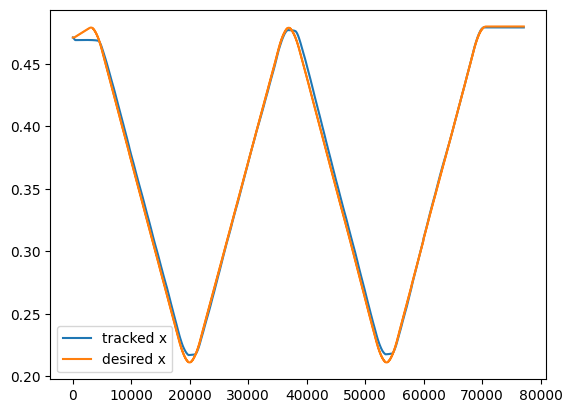

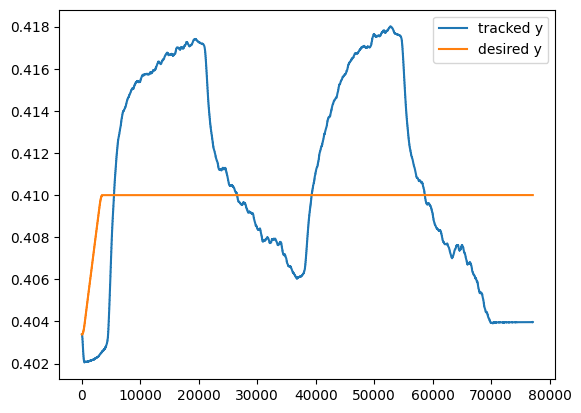

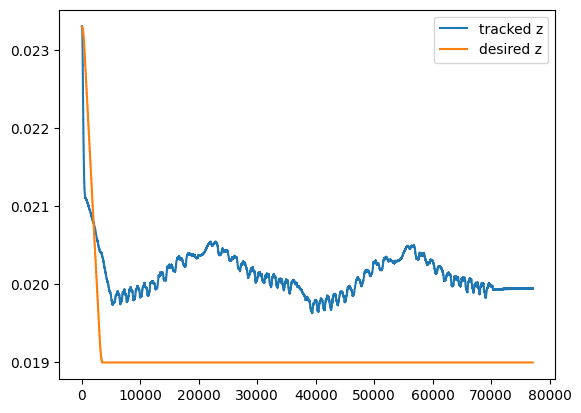

In [18]:
import matplotlib.pyplot as plt
P_EE_list = np.array(P_EE_list)
P_EE_d_list = np.array(P_EE_d_list)
plt.figure(0)
plt.plot(P_EE_list[:,0], label='tracked x')
plt.plot(P_EE_d_list[:,0], label='desired x')
plt.legend()

plt.figure(1)
plt.plot(P_EE_list[:,1], label='tracked y')
plt.plot(P_EE_d_list[:,1], label='desired y')
plt.legend()

plt.figure(2)
plt.plot(P_EE_list[:,2], label='tracked z')
plt.plot(P_EE_d_list[:,2], label='desired z')
plt.legend()